In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass 
password = getpass.getpass()
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import neighbors
from sklearn.preprocessing import OneHotEncoder


········


### 1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features. Use the data from 2005.


In [2]:

# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT f.title AS film
, f.rental_rate
        , f.rating
, CONCAT(ac.first_name,' ',ac.last_name) AS actor
, cat.name AS category
, i.store_id
, c.country
, r.may
        
FROM film f
LEFT JOIN film_actor fa
USING (film_id)
LEFT JOIN actor ac
USING (actor_id)
LEFT JOIN inventory i
USING (film_id)
JOIN film_category fc
USING (film_id)
JOIN category cat
USING (category_id)
LEFT JOIN (SELECT *
, DATE_FORMAT(rental_date, '%%m') AS may
FROM rental
WHERE DATE_FORMAT(rental_date, '%%m') = 05
) r
USING (inventory_id)
LEFT JOIN customer cst
USING (customer_id)
LEFT JOIN address a
USING (address_id)
LEFT JOIN city cty
USING (city_id)
LEFT JOIN country c
USING (country_id)

GROUP BY film
;'''

sakila = pd.read_sql_query(query, engine)
sakila.head()
# empty values are None
# null values as NaN

,film,rental_rate,rating,actor,category,store_id,country,may
0,AMADEUS HOLY,0.99,PG,JOHNNY LOLLOBRIGIDA,Action,1.0,None,None
1,AMERICAN CIRCUS,4.99,R,KEVIN BLOOM,Action,1.0,Brazil,05
2,ANTITRUST TOMATOES,2.99,NC-17,BETTE NICHOLSON,Action,1.0,Germany,05
3,ARK RIDGEMONT,0.99,NC-17,PARKER GOLDBERG,Action,NaN,None,None
4,BAREFOOT MANCHURIAN,2.99,G,JENNIFER DAVIS,Action,1.0,None,None


In [3]:
sakila.dtypes

film            object
rental_rate    float64
rating          object
actor           object
category        object
store_id       float64
country         object
may             object
dtype: object

### 2. Create a query to get the list of films and a boolean indicating if it was rented last month (August 2005). This would be our target variable.

In [4]:
sakila['may_rented'] = np.where(sakila['may'] == '05',True,False)
sakila.head(10)

,film,rental_rate,rating,actor,category,store_id,country,may,may_rented
0,AMADEUS HOLY,0.99,PG,JOHNNY LOLLOBRIGIDA,Action,1.0,None,None,False
1,AMERICAN CIRCUS,4.99,R,KEVIN BLOOM,Action,1.0,Brazil,05,True
2,ANTITRUST TOMATOES,2.99,NC-17,BETTE NICHOLSON,Action,1.0,Germany,05,True
3,ARK RIDGEMONT,0.99,NC-17,PARKER GOLDBERG,Action,NaN,None,None,False
4,BAREFOOT MANCHURIAN,2.99,G,JENNIFER DAVIS,Action,1.0,None,None,False
5,BERETS AGENT,2.99,PG-13,GRACE MOSTEL,Action,1.0,None,None,False
6,BRIDE INTRIGUE,0.99,G,ANGELA HUDSON,Action,1.0,None,None,False
7,BULL SHAWSHANK,0.99,NC-17,NICK WAHLBERG,Action,1.0,None,None,False
8,CADDYSHACK JEDI,0.99,NC-17,ED CHASE,Action,2.0,Turkey,05,True
9,CAMPUS REMEMBER,2.99,R,MATTHEW JOHANSSON,Action,1.0,None,None,False


In [5]:
sakila.shape


(1000, 9)

### 3. Read the data into a Pandas dataframe.

In [6]:
type(sakila)
sakila = sakila.drop('may', axis= 1)
type(sakila)


pandas.core.frame.DataFrame

In [7]:
sakila['store_id'] = sakila['store_id'].astype(object) 

In [8]:
print(sakila.dtypes)

film            object
rental_rate    float64
rating          object
actor           object
category        object
store_id        object
country         object
may_rented        bool
dtype: object


In [9]:
sakila.head()

,film,rental_rate,rating,actor,category,store_id,country,may_rented
0,AMADEUS HOLY,0.99,PG,JOHNNY LOLLOBRIGIDA,Action,1.0,None,False
1,AMERICAN CIRCUS,4.99,R,KEVIN BLOOM,Action,1.0,Brazil,True
2,ANTITRUST TOMATOES,2.99,NC-17,BETTE NICHOLSON,Action,1.0,Germany,True
3,ARK RIDGEMONT,0.99,NC-17,PARKER GOLDBERG,Action,NaN,None,False
4,BAREFOOT MANCHURIAN,2.99,G,JENNIFER DAVIS,Action,1.0,None,False


In [10]:
sakila.shape

(1000, 8)

### 4. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [11]:
X = sakila.drop('may_rented', axis= 1)
y = sakila['may_rented']
X.head()

,film,rental_rate,rating,actor,category,store_id,country
0,AMADEUS HOLY,0.99,PG,JOHNNY LOLLOBRIGIDA,Action,1.0,None
1,AMERICAN CIRCUS,4.99,R,KEVIN BLOOM,Action,1.0,Brazil
2,ANTITRUST TOMATOES,2.99,NC-17,BETTE NICHOLSON,Action,1.0,Germany
3,ARK RIDGEMONT,0.99,NC-17,PARKER GOLDBERG,Action,NaN,None
4,BAREFOOT MANCHURIAN,2.99,G,JENNIFER DAVIS,Action,1.0,None


In [12]:
sakila.shape

(1000, 8)

In [13]:
y.head(10)

0    False
1     True
2     True
3    False
4    False
5    False
6    False
7    False
8     True
9    False
Name: may_rented, dtype: bool

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42 )

In [15]:
# Scaling
X_train_num = X_train.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = object)

X_train_cat = X_train_cat.drop(['film','actor','country'], axis =1)

transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer
X_train_normalized = transformer.transform(X_train_num)
X_train_norm = pd.DataFrame(X_train_normalized)


In [16]:
#X_train_cat = X_train_cat[['film', 'rating', 'actor','category','store_id', 'country']].fillna('None')

# hot_encoder = OneHotEncoder().fit(X_train_cat)
# hot_encoded = hot_encoder.transform(X_train_cat).toarray()
# hot_cols = hot_encoder.categories_
# hot_encoded = pd.DataFrame(hot_encoded, columns = hot_cols)
# hot_encoded.head()



hot_encoder = OneHotEncoder(drop='first').fit(X_train_cat)
hot_encoded = hot_encoder.transform(X_train_cat).toarray()
hot_cols = hot_encoder.get_feature_names_out(input_features=X_train_cat.columns)
hot_encoded = pd.DataFrame(hot_encoded, columns = [i.lower() for i in hot_cols])
print(hot_encoded.shape)
hot_encoded.head()


(800, 21)


,rating_nc-17,rating_pg,rating_pg-13,rating_r,category_animation,category_children,category_classics,category_comedy,category_documentary,category_drama,...,category_foreign,category_games,category_horror,category_music,category_new,category_sci-fi,category_sports,category_travel,store_id_2.0,store_id_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


C:\Users\satur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


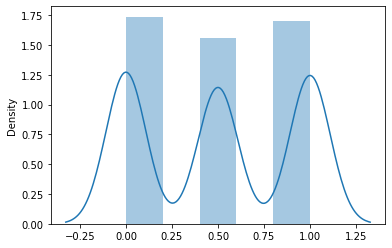

In [17]:
sns.distplot(X_train_norm)
plt.show()

In [18]:
#X_train_transformed = np.concatenate([X_train_norm, X_train_cat], axis=1)
X_train_transformed = np.concatenate([X_train_norm,hot_encoded], axis=1)
# we should add one hot encoded to the X_train_cat "hot_encoded"

In [19]:
pd.DataFrame(X_train_transformed)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
796,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
798,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 5. Create a logistic regression model to predict this variable from the cleaned data.

In [20]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train_transformed, y_train)

In [21]:
classification

LogisticRegression(multi_class='multinomial', random_state=0)

In [22]:
X_test_num = X_test.select_dtypes(include = np.number)
X_test_cat = X_test.select_dtypes(include = object)

X_test_cat = X_test_cat.drop(['film','actor','country'], axis =1)


#transformer = MinMaxScaler().fit(X_test_num) # need to keep transformer
X_test_normalized = transformer.transform(X_test_num)
X_test_norm = pd.DataFrame(X_test_normalized)


In [23]:
X_test_cat

,rating,category,store_id
521,R,Foreign,2.0
737,PG,Music,1.0
740,NC-17,Music,1.0
660,G,Horror,2.0
411,NC-17,Drama,1.0
...,...,...,...
408,R,Drama,1.0
332,PG-13,Documentary,1.0
208,R,Classics,1.0
613,PG-13,Games,1.0


In [24]:
#hot_encoder_test = OneHotEncoder(drop='first').fit(X_test_cat)
hot_encoded_test = hot_encoder.transform(X_test_cat).toarray()
hot_cols_test = hot_encoder.get_feature_names_out(input_features=X_test_cat.columns)
hot_encoded_test = pd.DataFrame(hot_encoded_test, columns = [i.lower() for i in hot_cols_test])
print(hot_encoded_test.shape)
hot_encoded_test.head()

(200, 21)


,rating_nc-17,rating_pg,rating_pg-13,rating_r,category_animation,category_children,category_classics,category_comedy,category_documentary,category_drama,...,category_foreign,category_games,category_horror,category_music,category_new,category_sci-fi,category_sports,category_travel,store_id_2.0,store_id_nan
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
X_test_transformed = np.concatenate([X_test_norm, hot_encoded_test], axis=1)

In [26]:
# Now we can make predictions on the test set:
predictions = classification.predict(X_test_transformed)
predictions

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [27]:
classification.score(X_test_transformed, y_test)

0.775

In [28]:
print(y_test.value_counts())

False    155
True      45
Name: may_rented, dtype: int64


In [29]:
pd.Series(predictions).value_counts()

False    200
dtype: int64

In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[155,   0],
       [ 45,   0]], dtype=int64)

#### As far as the data is concerned for the predictions, We have very less amount of true values available for the test so we decided that hot end encoder is not valiant model for testing. And we decided to go for that KNN classifier:

In [31]:
# bonus: KNN classifier: look at nearest neighbours and use the majority to determine class
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

0.71

In [32]:
confusion_matrix(y_test, predictions_clf)

array([[136,  19],
       [ 39,   6]], dtype=int64)

In [33]:
pd.Series(y_test).value_counts()

False    155
True      45
Name: may_rented, dtype: int64

In [34]:
pd.Series(predictions_clf).value_counts()

False    175
True      25
dtype: int64

In [35]:
# bonus: KNN classifier: look at nearest neighbours and use the majority to determine class
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=7, weights='uniform')
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

0.735

In [36]:
confusion_matrix(y_test, predictions_clf)

array([[143,  12],
       [ 41,   4]], dtype=int64)

In [37]:
pd.Series(y_test).value_counts()

False    155
True      45
Name: may_rented, dtype: int64

In [38]:
pd.Series(predictions_clf).value_counts()

False    184
True      16
dtype: int64

In [39]:
# bonus: KNN classifier: look at nearest neighbours and use the majority to determine class
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform')
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

0.69

In [40]:
confusion_matrix(y_test, predictions_clf)

array([[133,  22],
       [ 40,   5]], dtype=int64)

In [41]:
pd.Series(y_test).value_counts()

False    155
True      45
Name: may_rented, dtype: int64

In [42]:
pd.Series(predictions_clf).value_counts()

False    173
True      27
dtype: int64

In [43]:
y_test_df = pd.DataFrame(y_test)
y_test_df.reset_index(inplace = True)
y_test_df.drop('index', axis = 1, inplace = True)
predictions_df = pd.DataFrame(predictions)
results = pd.concat([y_test_df, predictions_df], axis = 1)
results.rename(columns = {'rented_may': 'Value', 0: 'guess'})


,may_rented,guess
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
195,False,False
196,False,False
197,True,False
198,False,False


### 6. Evaluate the results.

In [44]:
# get the data
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT f.title AS film
, f.rental_rate
        , f.rating
, CONCAT(ac.first_name,' ',ac.last_name) AS actor
, cat.name AS category
, i.store_id
, c.country
, r.june
        
FROM film f
LEFT JOIN film_actor fa
USING (film_id)
LEFT JOIN actor ac
USING (actor_id)
LEFT JOIN inventory i
USING (film_id)
JOIN film_category fc
USING (film_id)
JOIN category cat
USING (category_id)
LEFT JOIN (SELECT *
, DATE_FORMAT(rental_date, '%%m') AS june
FROM rental
WHERE DATE_FORMAT(rental_date, '%%m') = 06
) r
USING (inventory_id)
LEFT JOIN customer cst
USING (customer_id)
LEFT JOIN address a
USING (address_id)
LEFT JOIN city cty
USING (city_id)
LEFT JOIN country c
USING (country_id)

GROUP BY film
;'''

sakila_june = pd.read_sql_query(query, engine)
sakila_june.head()
# empty values are None
# null values as NaN

,film,rental_rate,rating,actor,category,store_id,country,june
0,AMADEUS HOLY,0.99,PG,JOHNNY LOLLOBRIGIDA,Action,1.0,None,None
1,AMERICAN CIRCUS,4.99,R,KEVIN BLOOM,Action,1.0,Finland,06
2,ANTITRUST TOMATOES,2.99,NC-17,BETTE NICHOLSON,Action,1.0,Philippines,06
3,ARK RIDGEMONT,0.99,NC-17,PARKER GOLDBERG,Action,NaN,None,None
4,BAREFOOT MANCHURIAN,2.99,G,JENNIFER DAVIS,Action,1.0,Canada,06


In [45]:
sakila_june.dtypes

film            object
rental_rate    float64
rating          object
actor           object
category        object
store_id       float64
country         object
june            object
dtype: object

In [46]:
sakila_june['june_rented'] = np.where(sakila_june['june'] == '06',True,False)
sakila_june.head(10)

,film,rental_rate,rating,actor,category,store_id,country,june,june_rented
0,AMADEUS HOLY,0.99,PG,JOHNNY LOLLOBRIGIDA,Action,1.0,None,None,False
1,AMERICAN CIRCUS,4.99,R,KEVIN BLOOM,Action,1.0,Finland,06,True
2,ANTITRUST TOMATOES,2.99,NC-17,BETTE NICHOLSON,Action,1.0,Philippines,06,True
3,ARK RIDGEMONT,0.99,NC-17,PARKER GOLDBERG,Action,NaN,None,None,False
4,BAREFOOT MANCHURIAN,2.99,G,JENNIFER DAVIS,Action,1.0,Canada,06,True
5,BERETS AGENT,2.99,PG-13,GRACE MOSTEL,Action,1.0,None,None,False
6,BRIDE INTRIGUE,0.99,G,ANGELA HUDSON,Action,1.0,None,None,False
7,BULL SHAWSHANK,0.99,NC-17,NICK WAHLBERG,Action,1.0,None,None,False
8,CADDYSHACK JEDI,0.99,NC-17,ED CHASE,Action,2.0,United Arab Emirates,06,True
9,CAMPUS REMEMBER,2.99,R,MATTHEW JOHANSSON,Action,1.0,None,None,False


In [47]:
sakila_june.shape

(1000, 9)

In [48]:
type(sakila)
sakila_june = sakila_june.drop('june', axis= 1)
type(sakila)

pandas.core.frame.DataFrame

In [49]:
sakila_june['store_id'] = sakila_june['store_id'].astype(object) 

In [50]:
print(sakila_june.dtypes)

film            object
rental_rate    float64
rating          object
actor           object
category        object
store_id        object
country         object
june_rented       bool
dtype: object


In [51]:
sakila_june.head()

,film,rental_rate,rating,actor,category,store_id,country,june_rented
0,AMADEUS HOLY,0.99,PG,JOHNNY LOLLOBRIGIDA,Action,1.0,None,False
1,AMERICAN CIRCUS,4.99,R,KEVIN BLOOM,Action,1.0,Finland,True
2,ANTITRUST TOMATOES,2.99,NC-17,BETTE NICHOLSON,Action,1.0,Philippines,True
3,ARK RIDGEMONT,0.99,NC-17,PARKER GOLDBERG,Action,NaN,None,False
4,BAREFOOT MANCHURIAN,2.99,G,JENNIFER DAVIS,Action,1.0,Canada,True


In [52]:
sakila_june.shape

(1000, 8)

In [53]:
Xj = sakila_june.drop('june_rented', axis= 1)
yj = sakila_june['june_rented']
Xj.head()

,film,rental_rate,rating,actor,category,store_id,country
0,AMADEUS HOLY,0.99,PG,JOHNNY LOLLOBRIGIDA,Action,1.0,None
1,AMERICAN CIRCUS,4.99,R,KEVIN BLOOM,Action,1.0,Finland
2,ANTITRUST TOMATOES,2.99,NC-17,BETTE NICHOLSON,Action,1.0,Philippines
3,ARK RIDGEMONT,0.99,NC-17,PARKER GOLDBERG,Action,NaN,None
4,BAREFOOT MANCHURIAN,2.99,G,JENNIFER DAVIS,Action,1.0,Canada


In [54]:
sakila.shape

(1000, 8)

In [55]:
Xj_train, Xj_test, yj_train, yj_test = train_test_split(Xj, yj, test_size = 0.2, random_state = 42 )

In [57]:
# Scaling
Xj_train_num = Xj_train.select_dtypes(include = np.number)
Xj_train_cat = Xj_train.select_dtypes(include = object)

Xj_train_cat = Xj_train_cat.drop(['film','actor','country'], axis =1)

#transformer_j = MinMaxScaler().fit(Xj_train_num) # need to keep transformer
Xj_train_normalized = transformer.transform(Xj_train_num)
Xj_train_norm = pd.DataFrame(Xj_train_normalized)

In [58]:
#hot_encoder_j = OneHotEncoder(drop='first').fit(Xj_train_cat)
hot_encoded_j = hot_encoder.transform(Xj_train_cat).toarray()
hot_cols_j = hot_encoder.get_feature_names_out(input_features=Xj_train_cat.columns)
hot_encoded_j = pd.DataFrame(hot_encoded, columns = [i.lower() for i in hot_cols_j])
print(hot_encoded_j.shape)
hot_encoded_j.head()

(800, 21)


,rating_nc-17,rating_pg,rating_pg-13,rating_r,category_animation,category_children,category_classics,category_comedy,category_documentary,category_drama,...,category_foreign,category_games,category_horror,category_music,category_new,category_sci-fi,category_sports,category_travel,store_id_2.0,store_id_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


C:\Users\satur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


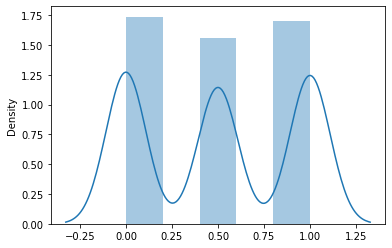

In [59]:
sns.distplot(Xj_train_norm)
plt.show()

In [96]:
Xj_train_transformed = np.concatenate([Xj_train_norm,hot_encoded_j], axis=1)

In [97]:
pd.DataFrame(Xj_train_transformed)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
796,0.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
798,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [98]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='saga',
                  multi_class='multinomial').fit(Xj_train_transformed, yj_train)
classification


LogisticRegression(multi_class='multinomial', random_state=0, solver='saga')

In [99]:
Xj_test_num = Xj_test.select_dtypes(include = np.number)
Xj_test_cat = Xj_test.select_dtypes(include = object)

Xj_test_cat = Xj_test_cat.drop(['film','actor','country'], axis =1)


#transformer = MinMaxScaler().fit(X_test_num) # need to keep transformer
Xj_test_normalized = transformer.transform(Xj_test_num)
Xj_test_norm = pd.DataFrame(Xj_test_normalized)

In [104]:
#hot_encoder_test = OneHotEncoder(drop='first').fit(X_test_cat)
hot_encodedj_test = hot_encoder.transform(Xj_test_cat).toarray()
hot_colsj_test = hot_encoder.get_feature_names_out(input_features=Xj_test_cat.columns)
hot_encodedj_test = pd.DataFrame(hot_encodedj_test, columns = [i.lower() for i in hot_colsj_test])
print(hot_encodedj_test.shape)
hot_encodedj_test.head()

(200, 21)


,rating_nc-17,rating_pg,rating_pg-13,rating_r,category_animation,category_children,category_classics,category_comedy,category_documentary,category_drama,...,category_foreign,category_games,category_horror,category_music,category_new,category_sci-fi,category_sports,category_travel,store_id_2.0,store_id_nan
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
Xj_test_transformed = np.concatenate([Xj_test_norm, hot_encodedj_test], axis=1)

In [106]:
predictionsj = classification.predict(Xj_test_transformed)
predictionsj



array([ True, False, False, False, False, False, False, False,  True,
       False,  True,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False,  True, False,
       False, False, False,  True,  True,  True, False, False, False,
       False, False, False, False, False,  True,  True, False,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False,  True,  True,  True, False, False,
       False,  True, False, False, False,  True, False, False, False,
        True, False, False, False, False, False, False,  True,  True,
       False, False,  True,  True,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True,

In [107]:
classification.score(Xj_test_transformed, yj_test)

0.54

In [111]:
print(yj_test.value_counts())


False    103
True      97
Name: june_rented, dtype: int64


In [112]:
pd.Series(predictionsj).value_counts()

False    143
True      57
dtype: int64

In [113]:
confusion_matrix(yj_test, predictionsj)


array([[77, 26],
       [66, 31]], dtype=int64)

In [114]:
# bonus: KNN classifier: look at nearest neighbours and use the majority to determine class
clf_j = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform')
clf_j.fit(Xj_train_transformed, yj_train)
predictionsj_clf = clf_j.predict(Xj_test_transformed)
clf_j.score(Xj_test_transformed, yj_test)


0.55

In [115]:
confusion_matrix(yj_test, predictionsj_clf)


array([[70, 33],
       [57, 40]], dtype=int64)

In [116]:
pd.Series(yj_test).value_counts()


False    103
True      97
Name: june_rented, dtype: int64

In [117]:
pd.Series(predictionsj_clf).value_counts()


False    127
True      73
dtype: int64

In [118]:
yj_df = pd.DataFrame(yj)
yj_df.reset_index(inplace = True)
yj_df.drop('index', axis = 1, inplace = True)
predictionsj_df = pd.DataFrame(predictionsj)
predictionsj_clf = pd.DataFrame(predictionsj_clf) # using neighbors
resultsj = pd.concat([yj_df, predictionsj_df, predictionsj_clf], axis = 1)
resultsj.columns = ['yj', 'guess_j', 'guess_clf_j']
resultsj


,yj,guess_j,guess_clf_j
0,False,True,True
1,True,False,False
2,True,False,False
3,False,False,False
4,True,False,True
...,...,...,...
995,True,NaN,NaN
996,True,NaN,NaN
997,True,NaN,NaN
998,False,NaN,NaN


In [119]:
june_prediction_table = pd.concat([sakila_june,
                                   predictionsj_df, predictionsj_clf],
                                  axis = 1)
june_prediction_table.columns = ['film','rental_rate', 'rating', 'actor', 'category', 'store_id', 'country', 'june_rented', 
                                 'guess_j', 'guess_clf_j']
june_prediction_table.head(60)

# The NaN we see in store_id and country are the films that were not rented in the month of June


,film,rental_rate,rating,actor,category,store_id,country,june_rented,guess_j,guess_clf_j
0,AMADEUS HOLY,0.99,PG,JOHNNY LOLLOBRIGIDA,Action,1.0,None,False,True,True
1,AMERICAN CIRCUS,4.99,R,KEVIN BLOOM,Action,1.0,Finland,True,False,False
2,ANTITRUST TOMATOES,2.99,NC-17,BETTE NICHOLSON,Action,1.0,Philippines,True,False,False
3,ARK RIDGEMONT,0.99,NC-17,PARKER GOLDBERG,Action,NaN,None,False,False,False
4,BAREFOOT MANCHURIAN,2.99,G,JENNIFER DAVIS,Action,1.0,Canada,True,False,True
5,BERETS AGENT,2.99,PG-13,GRACE MOSTEL,Action,1.0,None,False,False,False
6,BRIDE INTRIGUE,0.99,G,ANGELA HUDSON,Action,1.0,None,False,False,False
7,BULL SHAWSHANK,0.99,NC-17,NICK WAHLBERG,Action,1.0,None,False,False,False
8,CADDYSHACK JEDI,0.99,NC-17,ED CHASE,Action,2.0,United Arab Emirates,True,True,True
9,CAMPUS REMEMBER,2.99,R,MATTHEW JOHANSSON,Action,1.0,None,False,False,True


#### The conclusion here is that the neighbors classifier does help resolve the inbalance of True vs False and provides a better prediction


In [121]:
june_prediction_table['store_id'] = june_prediction_table['store_id'].fillna(0)
june_prediction_table.head(60)
june_prediction_table.loc[june_prediction_table['store_id'] == 0]

# Here we see where the predictions (guesses) predicted a film would be rented that was not rented in the month of June


,film,rental_rate,rating,actor,category,store_id,country,june_rented,guess_j,guess_clf_j
3,ARK RIDGEMONT,0.99,NC-17,PARKER GOLDBERG,Action,0.0,None,False,False,False
25,FIREHOUSE VIETNAM,0.99,G,SANDRA PECK,Action,0.0,None,False,False,False
51,SKY MIRACLE,2.99,PG,ELVIS MARX,Action,0.0,None,False,False,False
66,ARGONAUTS TOWN,0.99,PG-13,JULIA BARRYMORE,Animation,0.0,None,False,False,False
86,FLOATS GARDEN,2.99,PG-13,RIP WINSLET,Animation,0.0,None,False,True,True
175,SISTER FREDDY,4.99,PG-13,SUSAN DAVIS,Children,0.0,None,False,False,True
186,WALLS ARTIST,4.99,PG,CHRIS BRIDGES,Children,0.0,None,False,False,False
190,ALICE FANTASIA,0.99,NC-17,WOODY HOFFMAN,Classics,0.0,None,False,True,False
239,TADPOLE PARK,2.99,PG,HELEN VOIGHT,Classics,0.0,None,False,NaN,NaN
243,VOLUME HOUSE,4.99,PG,AUDREY OLIVIER,Classics,0.0,None,False,NaN,NaN
